In [1]:
import numpy as np
import mne
import matplotlib.pyplot as plt
import math
from golomb_code import encode, decode
import os
from scipy.interpolate import make_interp_spline

In [2]:
### data 1 compression - filtered data
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 15})

In [3]:
file = '4b5c_nofilter.edf'
data1 = mne.io.read_raw_edf(file)
data1.info

Extracting EDF parameters from /home/ifire/EEG/H-IoT-Golob-Rice-Compression-Automation/EEG data/4b5c_nofilter.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Measurement date,"April 27, 2022 07:50:40 GMT"
Experimenter,Unknown
Participant,X
Digitized points,Not available
Good channels,6 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,125.00 Hz
Highpass,0.00 Hz
Lowpass,62.50 Hz


In [4]:
data1.ch_names

['ch1_LF5-FpZ',
 'ch2_OTE_L-FpZ',
 'ch3_BE_L-FpZ',
 'ch4_RF6-FpZ',
 'ch5_OTE_R-FpZ',
 'ch6_BE_R-FpZ']

In [5]:
channel_names ={'ch1_LF5-FpZ': 'LF',
                'ch2_OTE_L-FpZ' :'LOE',
                 'ch3_BE_L-FpZ':'LBE',
                'ch4_RF6-FpZ' : 'RF',
               'ch5_OTE_R-FpZ': 'ROE',
               'ch6_BE_R-FpZ' : 'LBE'}

In [6]:
data1.rename_channels(mapping=channel_names, allow_duplicates=True)
data1.ch_names

/tmp/ipykernel_1378772/3348458617.py:1: RuntimeWarning: Channel names are not unique, found duplicates for: {'LBE'}. Applying running numbers for duplicates.
  data1.rename_channels(mapping=channel_names, allow_duplicates=True)


['LF', 'LOE', 'LBE-0', 'RF', 'ROE', 'LBE-1']

Setting up low-pass filter at 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 43 samples (0.344 s)



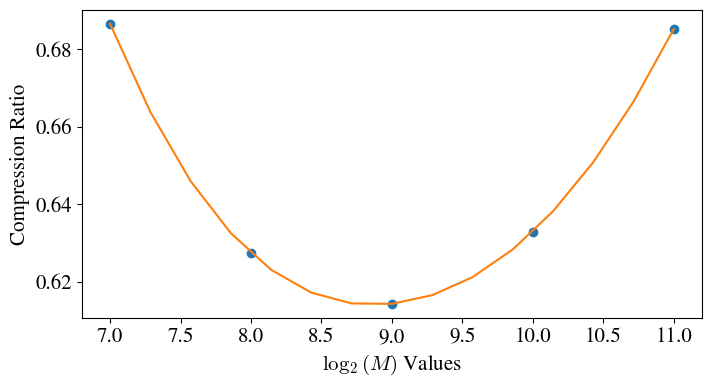

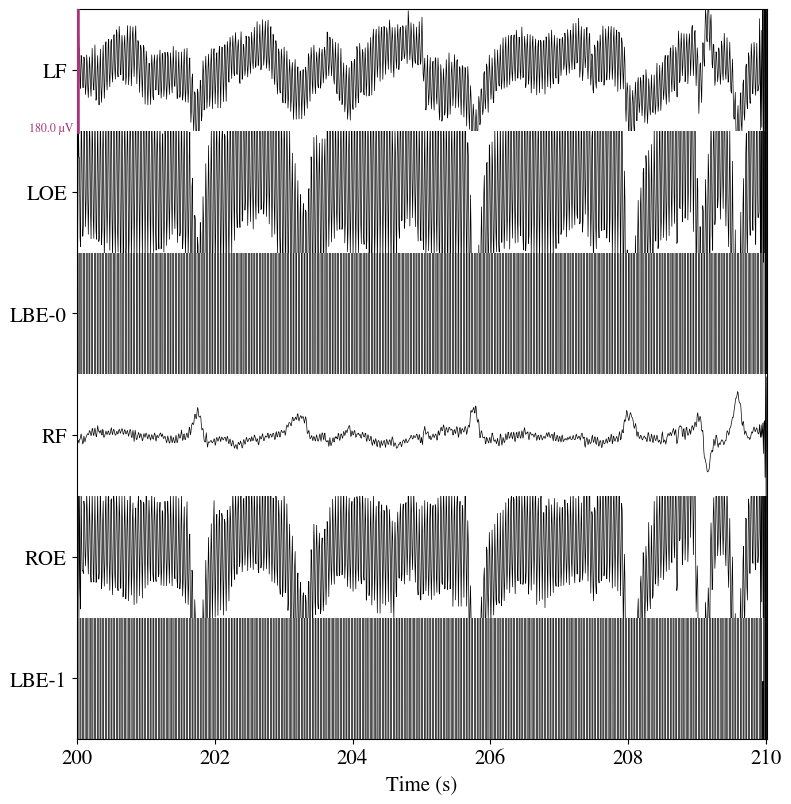

In [31]:
fig = data1.plot( start = 200,scalings='0.00009', clipping=0.5, remove_dc=True, lowpass =40, show_scrollbars=False, filtorder = 0, theme='auto');
fig.savefig('EEG_unfiltered.pdf', bbox_inches='tight')

In [8]:
EEG_raw_data  = data1.get_data()
SCALE=1e5 ## sclaed by 100000
raw_data= EEG_raw_data*SCALE

In [9]:
raw_data.shape

(6, 152875)

In [10]:
def compression_ratio(eeg_raw: np.ndarray, raw_file_size: float) -> None:
    min_val = abs(eeg_raw.min())
    non_neg_val = eeg_raw + min_val + 1
    
    np_non_neg_val = np.array(non_neg_val)
    k_min = math.floor(math.log2((2/3) * (np_non_neg_val.mean() + 1)))
    k_max = math.ceil(math.log2(np_non_neg_val.mean()))
    numerator = math.log10((math.sqrt(5) + 1) / 2 - 1)
    denominator = np.log10(np_non_neg_val.mean() / (np_non_neg_val.mean() + 1))
    k_geo = 1 + math.floor(math.log2(numerator / denominator))
    
    k_dict = {'k_min': k_min, 'k_max': k_max, 'k_geo': k_geo}
    
    non_neg_int_val = [int(val) for val in non_neg_val]
    print(k_dict)
    pass

    for x, y in k_dict.items():
        temp_code_words = [encode(val, y) for val in non_neg_int_val]  # Assuming encode is defined
        
        file_name = f'code_non_filter_words_channel_4_{x}.txt'
        with open(file_name, 'w') as file:
            for val in temp_code_words:
                file.write(val + "\n")
        temp_code_words = []
                
    for x in k_dict.keys():
        file_name = f'code_non_filter_words_channel_4_{x}.txt'
        file_size = os.path.getsize(file_name)
        print(f'the file size of the {x} is {file_size}')
        print(f'the compression ratio for {x} is {file_size / raw_file_size}')


### non filtered data
channel 1

In [11]:
with open('raw_non_filter_channel_1.txt', 'w') as file:
    for val in raw_data[0]:
        file.write(str(val) + "\n")

In [12]:
raw_non_filter_channel_1_size = os.path.getsize('raw_non_filter_channel_1.txt')
raw_non_filter_channel_1_size 

2869322

In [13]:
compression_ratio(raw_data[0], raw_non_filter_channel_1_size)

{'k_min': 8, 'k_max': 10, 'k_geo': 9}
the file size of the k_min is 1799452
the compression ratio for k_min is 0.6271349120105726
the file size of the k_max is 1835724
the compression ratio for k_max is 0.6397762258819331
the file size of the k_geo is 1799304
the compression ratio for k_geo is 0.62708333188119


channel 2

In [14]:
with open('raw_non_filter_channel_2.txt', 'w') as file:
    for val in raw_data[1]:
        file.write(str(val) + "\n")

In [15]:
raw_non_filter_channel_2_size = os.path.getsize('raw_non_filter_channel_2.txt')
raw_non_filter_channel_2_size 

2898168

In [16]:
compression_ratio(raw_data[1], raw_non_filter_channel_2_size)

{'k_min': 8, 'k_max': 10, 'k_geo': 9}
the file size of the k_min is 1820182
the compression ratio for k_min is 0.6280457171564934
the file size of the k_max is 1836324
the compression ratio for k_max is 0.6336154425830387
the file size of the k_geo is 1779280
the compression ratio for k_geo is 0.6139326636689109


channel 4

In [17]:
with open('raw_non_filter_channel_3.txt', 'w') as file:
    for val in raw_data[3]:
        file.write(str(val) + "\n")

In [18]:
raw_non_filter_channel_4_size = os.path.getsize('raw_non_filter_channel_3.txt')
raw_non_filter_channel_4_size 

2882473

In [19]:
compression_ratio(raw_data[3], raw_non_filter_channel_4_size)

{'k_min': 8, 'k_max': 10, 'k_geo': 9}


the file size of the k_min is 1834246
the compression ratio for k_min is 0.6363445555257586
the file size of the k_max is 1835725
the compression ratio for k_max is 0.6368576566025076
the file size of the k_geo is 1834241
the compression ratio for k_geo is 0.6363428209041334


channel 5

In [20]:
with open('raw_non_filter_channel_5.txt', 'w') as file:
    for val in raw_data[4]:
        file.write(str(val) + "\n")

In [21]:
raw_non_filter_channel_5_size = os.path.getsize('raw_non_filter_channel_5.txt')
raw_non_filter_channel_5_size 

2900569

In [22]:
compression_ratio(raw_data[4], raw_non_filter_channel_5_size)

{'k_min': 8, 'k_max': 10, 'k_geo': 9}


the file size of the k_min is 1790536
the compression ratio for k_min is 0.6173050873811311
the file size of the k_max is 1835670
the compression ratio for k_max is 0.6328654826001381
the file size of the k_geo is 1781714
the compression ratio for k_geo is 0.6142636151734366


In [23]:
### averaging over channel 
k_min_channel_wide = (0.6271349120105726 + 0.6280457171564934 + 0.6363445555257586 + 0.6173050873811311)/4
k_max_channel_wide = (0.6397762258819331 + 0.6336154425830387 + 0.6368576566025076 + 0.6328654826001381)/4
k_geo_channel_wide = (0.62708333188119 + 0.6139326636689109 + 0.6363428209041334 + 0.6142636151734366)/4

k_min_channel_wide, k_max_channel_wide, k_geo_channel_wide

(0.627207568018489, 0.6357787019169043, 0.6229056079069177)

In [24]:
import numpy as np
import math
import os

def compression_ratio(eeg_raw: np.ndarray, raw_file_size: float) -> None:
    min_val = abs(eeg_raw.min())
    non_neg_val = eeg_raw + min_val + 1
    
    np_non_neg_val = np.array(non_neg_val)
    k_min = math.floor(math.log2((2/3) * (np_non_neg_val.mean() + 1)))
    k_max = math.ceil(math.log2(np_non_neg_val.mean()))
    numerator = math.log10((math.sqrt(5) + 1) / 2 - 1)
    denominator = np.log10(np_non_neg_val.mean() / (np_non_neg_val.mean() + 1))
    k_geo = 1 + math.floor(math.log2(numerator / denominator))
    
    k_dict = {'k_min': k_min, 'k_max': k_max, 'k_geo': k_geo}
    
    non_neg_int_val = [int(val) for val in non_neg_val]
    print(k_dict)
    
    k_val = [7, 11]
    
    for y in k_val:
        temp_code_words = [encode(val, y) for val in non_neg_int_val]
        file_name = f'code_filter_words_channel_other_{y}.txt'
        with open(file_name, 'w') as file:
            for val in temp_code_words:
                file.write(val + "\n")
        temp_code_words = []
        
    for y in k_val:
        file_name = f'code_filter_words_channel_other_{y}.txt'
        file_size = os.path.getsize(file_name)
        print(f'the file size of the {y} is {file_size}')
        print(f'the compression ratio for {y} is {file_size / raw_file_size}')

In [25]:
compression_ratio(raw_data[4], raw_non_filter_channel_5_size)

{'k_min': 8, 'k_max': 10, 'k_geo': 9}


the file size of the 7 is 1991351
the compression ratio for 7 is 0.68653805511953
the file size of the 11 is 1987375
the compression ratio for 11 is 0.6851672895904217


In [26]:
k_vals = np.array([7,8, 9, 10, 11])
code_rate = np.array([0.68653805511953, 0.6273050873811311, 0.6142636151734366,  0.6328654826001381, 0.6851672895904217])
code_rate_spline = make_interp_spline(k_vals, code_rate)
k_vals_2= np.linspace(k_vals.min(), k_vals.max(),15)

code_rate_spline_values = code_rate_spline(k_vals_2)

plt.figure(figsize=(8, 4))
plt.plot(k_vals, code_rate, 'o')
plt.plot(k_vals_2, code_rate_spline_values)
plt.ylabel('Compression Ratio')
plt.xlabel(r'$\log_2(M) $ Values')
plt.savefig('eeg_convex_curve_non_filtered.pdf', bbox_inches='tight')

In [27]:
def compression_ratio(eeg_raw: np.ndarray,  y) -> None:
    min_val = abs(eeg_raw.min())
    non_neg_val = eeg_raw + min_val + 1
    
    np_non_neg_val = np.array(non_neg_val)
    k_min = math.floor(math.log2((2/3) * (np_non_neg_val.mean() + 1)))
    k_max = math.ceil(math.log2(np_non_neg_val.mean()))
    numerator = math.log10((math.sqrt(5) + 1) / 2 - 1)
    denominator = np.log10(np_non_neg_val.mean() / (np_non_neg_val.mean() + 1))
    k_geo = 1 + math.floor(math.log2(numerator / denominator))
    
    k_dict = {'k_min': k_min, 'k_max': k_max, 'k_geo': k_geo}
    
    non_neg_int_val = [int(val) for val in non_neg_val]
    
    temp_code_words = [encode(val, y) for val in non_neg_int_val]
    # print(k_dict)
    
    # k_val = [9, 13]
    
    # for y in k_val:
        
    #     file_name = f'code_filter_words_channel_other_{y}.txt'
    #     with open(file_name, 'w') as file:
    #         for val in temp_code_words:
    #             file.write(val + "\n")
    #     temp_code_words = []
        
    # for y in k_val:
    #     file_name = f'code_filter_words_channel_other_{y}.txt'
    #     file_size = os.path.getsize(file_name)
    #     print(f'the file size of the {y} is {file_size}')
    #     print(f'the compression ratio for {y} is {file_size / raw_file_size}')

In [28]:
raw_data.shape

(6, 152875)

In [29]:
data1.ch_names

['LF', 'LOE', 'LBE-0', 'RF', 'ROE', 'LBE-1']

In [30]:
%timeit compression_ratio(raw_data[0], 11)
%timeit compression_ratio(raw_data[1], 11)
%timeit compression_ratio(raw_data[3], 11)
%timeit compression_ratio(raw_data[4], 11)

38.8 ms ± 924 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
38.6 ms ± 499 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
37.5 ms ± 296 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
37.5 ms ± 320 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
